In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

In [ ]:
import os
os.makedirs('Data Files', exist_ok=True)

# Load gene expression data and labels
feature_data = pd.read_csv('Data Files/gene_expression.csv')
target_data = pd.read_csv('Data Files/labels.csv')

feature_data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
print(f'feature_data shape: {feature_data.shape}, target_data shape: {target_data.shape}')

# Merge features and labels by sample ID
df = pd.merge(feature_data, target_data, on='sample_id', how='inner')

# Remove metadata column that was accidentally included
df.drop(columns=['!series_matrix_table_end'], inplace=True)

print(f'df shape: {df.shape}')
df.head()

feature_data shape: (286, 22285), target_data shape: (286, 2)
df shape: (286, 22285)


,sample_id,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,bone_relapse
0,GSM36777,3848.1,228.9,213.1,1009.4,31.8,551.5,176.7,11.9,309.3,...,661.5,33168.9,25644.4,11.1,9.2,25.0,4.2,7.0,10.0,0
1,GSM36778,6520.9,112.5,189.8,2083.3,145.8,802.8,278.4,28.3,449.0,...,716.1,54401.4,40720.0,17.1,62.0,21.4,9.3,11.2,15.7,0
2,GSM36779,5285.7,178.4,269.7,1203.4,42.5,557.5,183.3,56.4,101.9,...,1189.3,61244.1,50878.7,6.4,8.4,7.4,7.1,64.0,4.1,0
3,GSM36780,4043.7,398.7,312.4,1104.4,108.2,568.5,187.7,42.1,899.1,...,801.1,62292.1,46870.8,13.5,10.8,16.0,4.6,12.2,7.3,0
4,GSM36781,4263.6,417.7,327.1,1043.3,69.2,653.2,185.8,21.8,3629.3,...,191.1,57295.1,40847.1,19.8,30.5,22.1,7.3,5.5,11.6,0


In [ ]:
# Extract gene names (exclude sample_id and target column)
gene_names = df.columns[1:-1]

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Features (genes): {len(gene_names)}")
print(f"Samples: {len(df)}")
print(f"\nBone_relapse distribution:")
print(df['bone_relapse'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nData types:\n{df.dtypes.value_counts()}")

DATA OVERVIEW
Shape: (286, 22285)
Features (genes): 22283
Samples: 286

Bone_relapse distribution:
bone_relapse
0    217
1     69
Name: count, dtype: int64

Missing values: 0

Data types:
float64    22283
object         1
int64          1
Name: count, dtype: int64


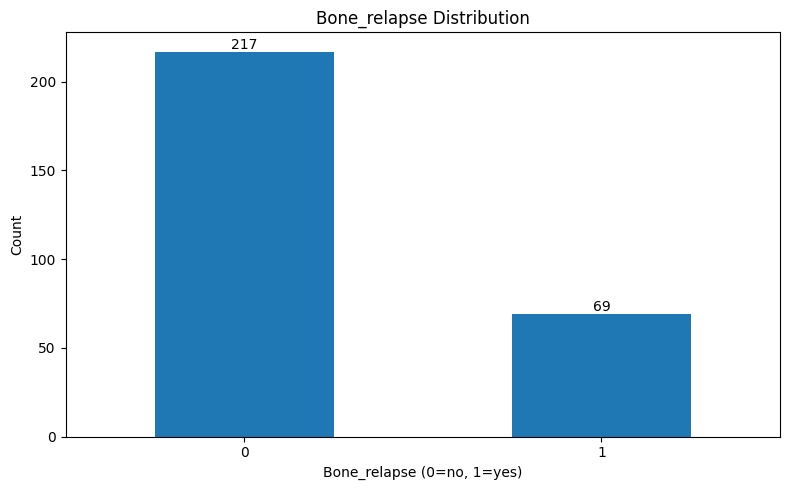

In [ ]:
# Check class distribution - important for understanding potential class imbalance
plt.figure(figsize=(8, 5))
df['bone_relapse'].value_counts().plot(kind='bar')
plt.title('Bone_relapse Distribution')
plt.xlabel('Bone_relapse (0=no, 1=yes)')
plt.ylabel('Count')
for i, v in enumerate(df['bone_relapse'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xticks(rotation=0)
plt.tight_layout()
os.makedirs('Outputs', exist_ok=True)
plt.savefig('Outputs/class_distribution.png', dpi=150)


# Data Preprocessing 

In [ ]:
# Separate features and target
X = df.drop(['sample_id', 'bone_relapse'], axis=1).values
y = df['bone_relapse'].values

# Critical: split before any preprocessing to prevent data leakage
# The test set must never influence training decisions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Keep a copy of original test data for inference testing later
X_test_original = X_test.copy()

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
test_Y = pd.Series(y_test)
train_Y = pd.Series(y_train)
print(f"spliting: test {test_Y.value_counts()}, train {train_Y.value_counts()}")


Train set: 228 samples
Test set: 58 samples
spliting: test 0    44
1    14
Name: count, dtype: int64, train 0    173
1     55
Name: count, dtype: int64


In [ ]:
# Check for missing values - gene expression data can have missing measurements
# I use median imputation because it's robust to outliers common in expression data
if np.isnan(X_train).any() or np.isnan(X_test).any():
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    
    # Fit on training data only, then transform both sets
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    print("Filled missing values with median (fitted on train only)")

else:
    print("No missing values found")



No missing values found


In [112]:
X_train.shape


(228, 22283)

In [113]:
X.shape

(286, 22283)

In [ ]:
# Two-stage feature selection for high-dimensional data
# With 22,283 genes, I need to reduce dimensionality while preserving predictive signal
# This approach is more robust than single-stage selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np

# Stage 1: Quick correlation filter to remove clearly irrelevant genes
def select_by_correlation(X, y, threshold=0.05):
    """
    Fast initial filter using correlation with target.
    Removes genes with minimal linear relationship to relapse status.
    """
    correlations = []
    for i in range(X.shape[1]):
        corr = np.abs(np.corrcoef(X[:, i], y)[0, 1])
        correlations.append(corr)
    
    correlations = np.array(correlations)
    selected_indices = np.where(correlations > threshold)[0]
    
    return selected_indices, correlations

print("Stage 1: Correlation filter...")
corr_indices, corr_scores = select_by_correlation(X_train, y_train, threshold=0.05)
X_train_filtered = X_train[:, corr_indices]
X_test_filtered = X_test[:, corr_indices]

print(f"  Filtered from {X_train.shape[1]} to {len(corr_indices)} features (correlation > 0.05)")
print(f"  Reduction: {(1 - len(corr_indices)/X_train.shape[1])*100:.1f}%")

# Stage 2: Mutual information to capture non-linear relationships
print("\nStage 2: Mutual Information selection...")

# I selected 1750 features as a balance between information retention and computational efficiency
n_final_features = min(1750, X_train_filtered.shape[1])

selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_final_features)
X_train_selected = selector_mi.fit_transform(X_train_filtered, y_train)
X_test_selected = selector_mi.transform(X_test_filtered)

# Map selected indices back to original gene names for interpretability
mi_selected_in_filtered = selector_mi.get_support(indices=True)
final_selected_indices = corr_indices[mi_selected_in_filtered]
selected_gene_names = [gene_names[i] for i in final_selected_indices]

print(f"  Selected {X_train_selected.shape[1]} final features")
print(f"  Total reduction: {X_train.shape[1]} → {X_train_selected.shape[1]} features")
print(f"  Final reduction: {(1 - X_train_selected.shape[1]/X_train.shape[1])*100:.1f}%")

X_train = X_train_selected
X_test = X_test_selected

Stage 1: Correlation filter...
  Filtered from 22283 to 13634 features (correlation > 0.05)
  Reduction: 38.8%

Stage 2: Mutual Information selection...
  Selected 1750 final features
  Total reduction: 22283 → 1750 features
  Final reduction: 92.1%


In [115]:
X_train.shape

(228, 1750)

In [ ]:
# Scale features to zero mean and unit variance
# Essential for SVM, logistic regression, and neural networks to perform well
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing complete (no data leakage!)")


Data preprocessing complete (no data leakage!)


# Model Training and Comparison

In [117]:
models = {}
results = {}

In [ ]:
# Model 1: Logistic Regression
# Starting with a simple baseline model that's interpretable and fast
print("\n" + "=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0
)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'accuracy': accuracy_lr,
    'predictions': y_pred_lr
}

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr))



MODEL 1: LOGISTIC REGRESSION
Accuracy: 0.7414

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84        44
           1       0.45      0.36      0.40        14

    accuracy                           0.74        58
   macro avg       0.63      0.61      0.62        58
weighted avg       0.72      0.74      0.73        58



In [ ]:
# Model 2: Random Forest
# Skipping Random Forest due to computational constraints
# With 1,750 features and 228 samples, building multiple trees becomes prohibitively expensive
# The computational cost scales poorly for this high-dimensional setting
print("\n" + "=" * 60)
print("MODEL 2: RANDOM FOREST - SKIPPED")
print("=" * 60)
print("Reason: High computational requirements")
print("- Dataset: 228 samples × 1,750 features (after feature selection)")
print("- Random Forest builds multiple trees, each evaluating splits across many features")
print("- Computational cost scales with: n_estimators × n_features × tree_depth")
print("- Other models (Logistic Regression, SVM, XGBoost) are more efficient for this data")
print("=" * 60)

# Skip Random Forest training due to computational constraints
# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1
# )
# rf_model.fit(X_train_scaled, y_train)
# y_pred_rf = rf_model.predict(X_test_scaled)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# 
# models['Random Forest'] = rf_model
# results['Random Forest'] = {
#     'accuracy': accuracy_rf,
#     'predictions': y_pred_rf
# }
# 
# print(f"Accuracy: {accuracy_rf:.4f}")
# print(f"\nClassification Report:")
# print(classification_report(y_test, y_pred_rf))
# 
# feature_importance = pd.DataFrame({
#     'Gene': selected_gene_names,
#     'Importance': rf_model.feature_importances_
# }).sort_values('Importance', ascending=False)
# 
# print(f"\nTop 10 Most Important Genes:")
# print(feature_importance.head(10))

print("\nContinuing with other models (SVM, XGBoost, Neural Network)...")



MODEL 2: RANDOM FOREST - SKIPPED
Reason: High computational requirements
- Dataset: 228 samples × 1,750 features (after feature selection)
- Random Forest builds multiple trees, each evaluating splits across many features
- Computational cost scales with: n_estimators × n_features × tree_depth
- Other models (Logistic Regression, SVM, XGBoost) are more efficient for this data

Continuing with other models (SVM, XGBoost, Neural Network)...


In [ ]:
# Model 3: Support Vector Machine
# SVMs work well with high-dimensional data and can find non-linear decision boundaries
print("\n" + "=" * 60)
print("MODEL 3: SUPPORT VECTOR MACHINE (SVM)")
print("=" * 60)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True
)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

models['SVM'] = svm_model
results['SVM'] = {
    'accuracy': accuracy_svm,
    'predictions': y_pred_svm
}

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


MODEL 3: SUPPORT VECTOR MACHINE (SVM)
Accuracy: 0.7586

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        44
           1       0.00      0.00      0.00        14

    accuracy                           0.76        58
   macro avg       0.38      0.50      0.43        58
weighted avg       0.58      0.76      0.65        58



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [ ]:
# Model 4: XGBoost
# Gradient boosting often performs well on structured data like gene expression
print("\n" + "=" * 60)
print("MODEL 4: XGBOOST")
print("=" * 60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

models['XGBoost'] = xgb_model
results['XGBoost'] = {
    'accuracy': accuracy_xgb,
    'predictions': y_pred_xgb
}

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


MODEL 4: XGBOOST
Accuracy: 0.7931

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        44
           1       0.75      0.21      0.33        14

    accuracy                           0.79        58
   macro avg       0.77      0.60      0.61        58
weighted avg       0.79      0.79      0.75        58



In [ ]:
# Model 5: Neural Network
# Multi-layer perceptron to capture complex non-linear patterns in gene expression
print("\n" + "=" * 60)
print("MODEL 5: NEURAL NETWORK")
print("=" * 60)

from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)
accuracy_nn = accuracy_score(y_test, y_pred_nn)

models['Neural Network'] = nn_model
results['Neural Network'] = {
    'accuracy': accuracy_nn,
    'predictions': y_pred_nn
}

print(f"Accuracy: {accuracy_nn:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nn))


MODEL 5: NEURAL NETWORK
Accuracy: 0.7586

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        44
           1       0.50      0.43      0.46        14

    accuracy                           0.76        58
   macro avg       0.66      0.65      0.65        58
weighted avg       0.75      0.76      0.75        58



# Model Evaluation and Comparison

In [ ]:
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

# Compare all models by accuracy
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print(comparison_df.to_string(index=False))

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.barh(comparison_df['Model'], comparison_df['Accuracy'])
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xlim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
os.makedirs('Outputs', exist_ok=True)
plt.savefig('Outputs/model_comparison.png', dpi=150)
plt.close()

# Identify best performing model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} (Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f})")

# Generate confusion matrix for best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_best = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
os.makedirs('Outputs', exist_ok=True)
plt.savefig('Outputs/confusion_matrix.png', dpi=150)
plt.close()


MODEL COMPARISON SUMMARY
              Model  Accuracy
            XGBoost  0.793103
                SVM  0.758621
     Neural Network  0.758621
Logistic Regression  0.741379

Best Model: XGBoost (Accuracy: 0.7931)


# Hyperparameter Tuning for Best Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING FOR BEST MODEL")
print("=" * 60)

# Tune the best performing model to see if we can improve performance
best_model_name = comparison_df.iloc[0]['Model']
original_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"Tuning hyperparameters for: {best_model_name}")
print(f"Original accuracy: {original_accuracy:.4f}")

# Define parameter grids for each model type
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
    base_model = SVC(random_state=42, probability=True)
    
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    
elif best_model_name == 'Neural Network':
    param_grid = {
        'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive']
    }
    base_model = MLPClassifier(random_state=42, max_iter=500, solver='adam', activation='relu')
    
else:
    print(f"Hyperparameter tuning not implemented for {best_model_name}")
    print("Using default parameters")
    tuned_model = best_model
    param_grid = None

# Perform grid search with cross-validation
if param_grid is not None:
    print(f"\nPerforming Grid Search with cross-validation...")
    print(f"Parameter grid: {param_grid}")
    
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    print("\nFitting grid search (this may take a few minutes)...")
    grid_search.fit(X_train_scaled, y_train)
    
    tuned_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"\n✅ Grid Search Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Score (AUC-ROC): {best_cv_score:.4f}")
    
    # Evaluate tuned model on test set
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    
    from sklearn.metrics import roc_auc_score, classification_report
    
    y_pred_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]
    auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    
    accuracy_original = original_accuracy
    improvement = accuracy_tuned - accuracy_original
    
    print(f"\n" + "=" * 60)
    print("COMPARISON: ORIGINAL vs TUNED")
    print("=" * 60)
    print(f"Original Accuracy: {accuracy_original:.4f}")
    print(f"Tuned Accuracy:    {accuracy_tuned:.4f}")
    print(f"Improvement:       {improvement:+.4f} ({improvement/accuracy_original*100:+.2f}%)")
    print(f"\nTuned Model AUC-ROC: {auc_tuned:.4f}")
    print(f"\nTuned Model Classification Report:")
    print(classification_report(y_test, y_pred_tuned))
    
    # Only update if tuned model performs better
    if accuracy_tuned > original_accuracy:
        best_model = tuned_model
        models[best_model_name] = tuned_model
        results[best_model_name]['accuracy'] = accuracy_tuned
        results[best_model_name]['predictions'] = y_pred_tuned
        print(f"\n✅ Using tuned {best_model_name} as final model")
    else:
        best_model = models[best_model_name]
        print(f"\n⚠️ Tuned model is worse. Keeping original {best_model_name}")
        print(f"Original Accuracy: {accuracy_original:.4f}")
        print(f"Tuned Accuracy:     {accuracy_tuned:.4f}")
        print(f"Difference:          {improvement:+.4f} ({improvement/accuracy_original*100:+.2f}%)")

else:
    best_model = models[best_model_name]
    print(f"Using default parameters for {best_model_name}")


HYPERPARAMETER TUNING FOR BEST MODEL
Tuning hyperparameters for: XGBoost
Original accuracy: 0.7931

Performing Grid Search with cross-validation...
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [3, 6, 9], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 0.9, 1.0]}

Fitting grid search (this may take a few minutes)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Grid Search Complete!
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score (AUC-ROC): 0.8460

COMPARISON: ORIGINAL vs TUNED
Original Accuracy: 0.7931
Tuned Accuracy:    0.7759
Improvement:       -0.0172 (-2.17%)

Tuned Model AUC-ROC: 0.6396

Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87        44
           1       0.67      0.14      0.24        14

    accuracy                           0.78        58
   macro avg       0.72      0.56      0.5

# Save Model and Create Inference Function

In [ ]:
import joblib
import os

# Save the best model and all preprocessing components for inference
os.makedirs('Models', exist_ok=True)

model_path = f'Models/{best_model_name.lower().replace(" ", "_")}_model.pkl'
scaler_path = 'Models/scaler.pkl'
corr_indices_path = 'Models/corr_indices.pkl'
selector_mi_path = 'Models/selector_mi.pkl'

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(corr_indices, corr_indices_path)
joblib.dump(selector_mi, selector_mi_path)

print(f"\nModel saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Correlation filter indices saved to: {corr_indices_path}")
print(f"Mutual Information selector saved to: {selector_mi_path}")

# Inference function for making predictions on new samples
def predict_relapse(gene_expression_data, model_path, scaler_path, corr_indices_path, selector_mi_path):
    """
    Predict relapse status from gene expression data.
    
    Important: Input must have exactly 22,283 features in the same order as training data.
    
    Parameters:
    -----------
    gene_expression_data : np.array or pd.DataFrame
        Gene expression values (n_samples × 22,283 genes)
    model_path : str
        Path to saved model
    scaler_path : str
        Path to saved scaler
    corr_indices_path : str
        Path to saved correlation filter indices
    selector_mi_path : str
        Path to saved mutual information selector
    
    Returns:
    --------
    prediction : int or array
        Predicted relapse status (0 = no relapse, 1 = relapse)
    probability : array
        Probability of relapse [P(no relapse), P(relapse)]
    """
    # Load all preprocessing components and model
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    corr_indices = joblib.load(corr_indices_path)
    selector_mi = joblib.load(selector_mi_path)
    
    if isinstance(gene_expression_data, pd.DataFrame):
        gene_expression_data = gene_expression_data.values
    
    # Verify input dimensions match training data
    if gene_expression_data.shape[1] != 22283:
        raise ValueError(f"Input must have 22,283 features (genes), but got {gene_expression_data.shape[1]}. "
                        f"Features must be in the same order as training data.")
    
    # Apply same preprocessing pipeline as training
    X_filtered = gene_expression_data[:, corr_indices]
    X_selected = selector_mi.transform(X_filtered)
    X_scaled = scaler.transform(X_selected)
    
    # Make prediction
    prediction = model.predict(X_scaled)
    probability = model.predict_proba(X_scaled)
    
    if len(prediction) == 1:
        return prediction[0], probability[0]
    else:
        return prediction, probability

# Test the inference function
print("\n" + "=" * 60)
print("TESTING INFERENCE FUNCTION")
print("=" * 60)

test_sample = X_test_original[0:1]
pred, prob = predict_relapse(test_sample, model_path, scaler_path, corr_indices_path, selector_mi_path)

print(f"True label: {y_test[0]}")
print(f"Predicted label: {pred}")
print(f"Probabilities: [No relapse: {prob[0]:.4f}, Relapse: {prob[1]:.4f}]")


Model saved to: Models/xgboost_model.pkl
Scaler saved to: Models/scaler.pkl
Correlation filter indices saved to: Models/corr_indices.pkl
Mutual Information selector saved to: Models/selector_mi.pkl

TESTING INFERENCE FUNCTION
True label: 0
Predicted label: 0
Probabilities: [No relapse: 0.8444, Relapse: 0.1556]
